<a href="https://colab.research.google.com/github/JayVeer18/MiniProject/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 
import scipy, numpy, shutil, os, nibabel
from tqdm import tqdm
import sys, getopt
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Data Preprocessing

In [ ]:
def convertnii2png(inputfile,outputfile,name):
    print('Input file is ', inputfile)
    print('Output folder is ', outputfile)

    # set fn as your 4d nifti file
    image_array = nibabel.load(inputfile).get_data()
    print(len(image_array.shape))

    # ask if rotate
    ask_rotate = input('Would you like to rotate the orientation? (y/n) ')

    if ask_rotate.lower() == 'y':
        ask_rotate_num = int(input('OK. By 90° 180° or 270°? '))
        if ask_rotate_num == 90 or ask_rotate_num == 180 or ask_rotate_num == 270:
            print('Got it. Your images will be rotated by {} degrees.'.format(ask_rotate_num))
        else:
            print('You must enter a value that is either 90, 180, or 270. Quitting...')
            sys.exit()
    elif ask_rotate.lower() == 'n':
        print('OK, Your images will be converted it as it is.')
    else:
        print('You must choose either y or n. Quitting...')
        sys.exit()

    # if 4D image inputted
    if len(image_array.shape) == 4:
        # set 4d array dimension values
        nx, ny, nz, nw = image_array.shape

        # set destination folder
        if not os.path.exists(outputfile):
            os.makedirs(outputfile)
            print("Created ouput directory: " + outputfile)

        print('Reading NIfTI file...')

        total_volumes = image_array.shape[3]
        total_slices = image_array.shape[2]

        # iterate through volumes
        for current_volume in range(0, total_volumes):
            slice_counter = 0
            # iterate through slices
            for current_slice in range(0, total_slices):
                if (slice_counter % 1) == 0:
                    # rotate or no rotate
                    if ask_rotate.lower() == 'y':
                        if ask_rotate_num == 90 or ask_rotate_num == 180 or ask_rotate_num == 270:
                            print('Rotating image...')
                            if ask_rotate_num == 90:
                                data = numpy.rot90(image_array[:, :, current_slice, current_volume])
                            elif ask_rotate_num == 180:
                                data = numpy.rot90(numpy.rot90(image_array[:, :, current_slice, current_volume]))
                            elif ask_rotate_num == 270:
                                data = numpy.rot90(numpy.rot90(numpy.rot90(image_array[:, :, current_slice, current_volume])))
                    elif ask_rotate.lower() == 'n':
                        data = image_array[:, :, current_slice, current_volume]

                    #alternate slices and save as png
                    print('Saving image...')
                    image_name = inputfile[:-4] + "_t" + "{:0>3}".format(str(current_volume+1)) + "_z" + "{:0>3}".format(str(current_slice+1))+ ".png"
                    imageio.imwrite(image_name, data)
                    print('Saved.')

                    #move images to folder
                    print('Moving files...')
                    src = image_name
                    shutil.move(src, outputfile)
                    slice_counter += 1
                    print('Moved.')

        print('Finished converting images')

    # else if 3D image inputted
    elif len(image_array.shape) == 3:
        # set 3d array dimension values
        nx, ny, nz = image_array.shape

        # set destination folder
        if not os.path.exists(outputfile):
            os.makedirs(outputfile)
            print("Created ouput directory: " + outputfile)

        print('Reading NIfTI file...')

        total_slices = image_array.shape[2]

        slice_counter = 0
        # iterate through slices
        for current_slice in range(0, total_slices):
            # alternate slices
            if (slice_counter % 1) == 0:
                # rotate or no rotate
                if ask_rotate.lower() == 'y':
                    if ask_rotate_num == 90 or ask_rotate_num == 180 or ask_rotate_num == 270:
                        if ask_rotate_num == 90:
                            data = numpy.rot90(image_array[:, :, current_slice])
                        elif ask_rotate_num == 180:
                            data = numpy.rot90(numpy.rot90(image_array[:, :, current_slice]))
                        elif ask_rotate_num == 270:
                            data = numpy.rot90(numpy.rot90(numpy.rot90(image_array[:, :, current_slice])))
                elif ask_rotate.lower() == 'n':
                    data = image_array[:, :, current_slice]

                #alternate slices and save as png
                if (slice_counter % 1) == 0:
                    print('Saving image...')
                    image_name = name + "{:0>3}".format(str(current_slice+1))+ ".png"
                    imageio.imwrite(image_name, data)
                    print('Saved.')

                    #move images to folder
                    print('Moving image...')
                    src = image_name
                    shutil.move(src, outputfile)
                    slice_counter += 1
                    print('Moved.')

        print('Finished converting images')
    else:
        print('Not a 3D or 4D Image. Please try again.')    

### Extracting The Training Images and corresponding Ground Truth Images

In [ ]:
!gdown --id 1oq92_SvNZz7pdV1R1zCkSyXRILxPRGVy
!unzip SemiSegData.zip

Downloading...
From: https://drive.google.com/uc?id=1oq92_SvNZz7pdV1R1zCkSyXRILxPRGVy
To: /content/SemiSegData.zip
188MB [00:04, 43.6MB/s]
Archive:  SemiSegData.zip
   creating: SemiSegData/
   creating: SemiSegData/images/
  inflating: SemiSegData/images/tr_im_z001.png  
  inflating: SemiSegData/images/tr_im_z002.png  
  inflating: SemiSegData/images/tr_im_z003.png  
  inflating: SemiSegData/images/tr_im_z004.png  
  inflating: SemiSegData/images/tr_im_z005.png  
  inflating: SemiSegData/images/tr_im_z006.png  
  inflating: SemiSegData/images/tr_im_z007.png  
  inflating: SemiSegData/images/tr_im_z008.png  
  inflating: SemiSegData/images/tr_im_z009.png  
  inflating: SemiSegData/images/tr_im_z010.png  
  inflating: SemiSegData/images/tr_im_z011.png  
  inflating: SemiSegData/images/tr_im_z012.png  
  inflating: SemiSegData/images/tr_im_z013.png  
  inflating: SemiSegData/images/tr_im_z014.png  
  inflating: SemiSegData/images/tr_im_z015.png  
  inflating: SemiSegData/images/tr_im_z01

### Converting images from .nii format to .png

In [ ]:
inputfile = r'C:\Users\SurendraGupta\Downloads\tr_im.nii\tr_im.nii'
outputfile = r'E:\sem7\SemiSegData\images'
#convertnii2png(inputfile,outputfile,'img')

#### The Stored Training Images

In [ ]:
plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(outputfile)[0:5]):
    fullpath = os.path.join(outputfile,file)
    img=cv2.imread(fullpath)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
plt.show()

FileNotFoundError: ignored

<Figure size 1080x1080 with 0 Axes>

#### Converting GroundTruth images from .nii format to .png

In [ ]:
inputfile = r'C:\Users\SurendraGupta\Downloads\tr_mask.nii\tr_mask.nii'
outputfile = r'E:\sem7\SemiSegData\mask'
#convertnii2png(inputfile,outputfile,'mask')

#### The Stored Ground Truth Images

In [ ]:
plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(outputfile)[0:5]):
    fullpath = os.path.join(outputfile,file)
    img=cv2.imread(fullpath)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
plt.show()

#### Converting Test images from .nii format to .png

In [ ]:
inputfile = r'C:\Users\SurendraGupta\Downloads\val_im.nii\val_im.nii'
outputfile = r'E:\sem7\SemiSegData\TestData'
#convertnii2png(inputfile,outputfile,'testimg')

#### The Stored Test Images

In [ ]:
plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(outputfile)[0:5]):
    fullpath = os.path.join(outputfile,file)
    img=cv2.imread(fullpath)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
plt.show()

### Input

In [ ]:
DATASET_PATH = r'/content/SemiSegData'
CATEGORIES =['images','mask']

In [ ]:
mas = []
imge = []
    
for filename in os.listdir(os.path.join(DATASET_PATH,CATEGORIES[0]) ):
    if filename.endswith('.png'):
        imge.append(filename)
for filename in os.listdir(os.path.join(DATASET_PATH,CATEGORIES[1]) ):
    if filename.endswith('.png'):
        mas.append(filename)
mas.sort()
imge.sort()

In [ ]:
X=[]
y=[]
for filename in imge:
    img=cv2.imread(os.path.join(os.path.join(DATASET_PATH,CATEGORIES[0]), filename),cv2.IMREAD_REDUCED_COLOR_2)
    X.append(img)
for filename in mas:
    img=cv2.imread(os.path.join(os.path.join(DATASET_PATH,CATEGORIES[1]), filename),cv2.IMREAD_REDUCED_GRAYSCALE_2)
    y.append(img)
X=np.array(X)
y=np.array(y)
X = X/255
y = y/255
y=np.expand_dims(y,3)
print('The shape of input : ',X.shape)
print('The shape of mask : ',y.shape)

The shape of input :  (100, 256, 256, 3)
The shape of mask :  (100, 256, 256, 1)


 ### Displaying Input Image and True Mask Image

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask',]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    plt.show()

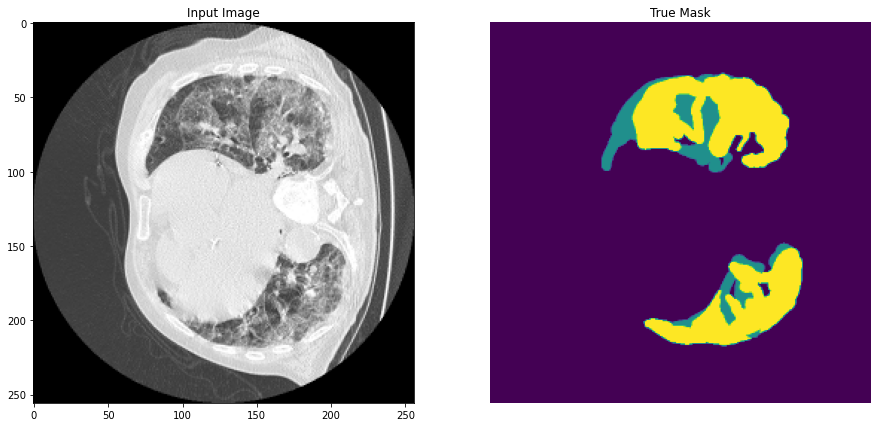

In [ ]:
display([X[0],y[0]])

### Proposed CNN Architecture for Image Segmentation
![Image Segmentation](https://ars.els-cdn.com/content/image/1-s2.0-S096007792030566X-gr9_lrg.jpg)

# Creating the Model

In [ ]:
def create_model(INPUT_SHAPE):
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size=(3, 3),strides=(1,1),padding="same", input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding="valid"))
    
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),strides=(1,1),padding="same"))
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(4, 4),strides=(2,2),padding="same"))
    model.add(Conv2D(filters = 2, kernel_size=(1, 1),strides=(1,1),padding="valid"))
    model.add(Activation('softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
model = create_model([256,256,3])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 32)      3

# Training the model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def displayImage(img):
    size = len(img)
    fig, ax = plt.subplots(1, size,figsize=(15,5))
    title = ['Training Image','Ground image','Predicted image']
    for i in range(size):
        ax[i].set_title(title[i])
        if (len(img[i].shape) >= 3 and img[i].shape[2] == 2):         
            img[i] = img[i][:,:,1]
        if (len(img[i].shape) == 2 ):
            ax[i].imshow(img[i])
        else:
            ax[i].imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        fig.tight_layout()
    plt.show()

In [ ]:
def show_predictions(X_test,y_test):
      pred_mask = model.predict(X_test)
      displayImage([X_test[3], y_test[3], pred_mask[3]]) 

In [ ]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(X_test,y_test)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
checkpoint = tf.keras.callbacks.ModelCheckpoint(r'Image_Segmetation.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

(256, 256, 3)
(256, 256, 3)
(256, 256, 1)
(256, 256, 1)
(256, 256, 2)
(256, 256)


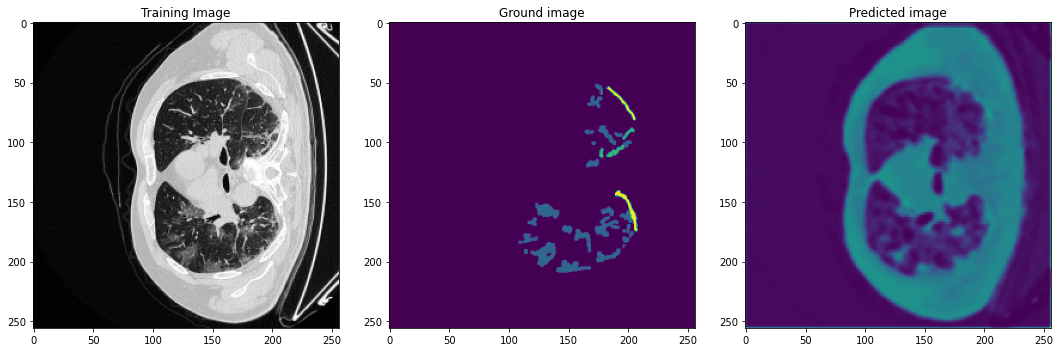


Sample Prediction after epoch 15


Epoch 00015: val_accuracy did not improve from 0.94753
5/5 [==============================] - 14s 3s/step - loss: 0.1118 - accuracy: 0.9219 - val_loss: 0.0992 - val_accuracy: 0.9475


In [ ]:
EPOCHS = 15
BS = 16
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = (len(X_train))// BS
VALIDATION_STEPS = (len(X_test))//BS
history = model.fit(x = X_train,
                   y = y_train,
                   epochs=EPOCHS,
                   batch_size = BS,
                   steps_per_epoch=STEPS_PER_EPOCH,
                   validation_steps=VALIDATION_STEPS,
                   validation_data=(X_test,y_test),
                   callbacks=[DisplayCallback(),checkpoint])

### Displaying predicted images

In [ ]:
def displayImage(img):
    size = len(img)
    fig, ax = plt.subplots(1, size,figsize=(15,5))
    title = ['Training Image','Ground image','Predicted image']
    for i in range(size):
        ax[i].set_title(title[i])
        if (len(img[i].shape) >= 3 and img[i].shape[2] == 2):         
            img[i] = img[i][:,:,1]
        if (len(img[i].shape) == 2 ):
            ax[i].imshow(img[i])
        else:
            ax[i].imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        fig.tight_layout()
    plt.show()
yhat = model.predict(X_test)

In [ ]:
li=[1,2,3,4,5,8]
for i in li:
    displayImage([X_test[i],y_test[i],yhat[i]])

# Accuracy plots

In [ ]:
def plothistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5))
    ax1.plot(history.history['accuracy'],'r-')
    ax1.plot(history.history['val_accuracy'],'b-')
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['Train Accuracy', 'Val Accuracy'], loc='upper right')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['Train Loss', 'Val Loss'], loc='upper right')
    plt.tight_layout()

In [ ]:
plothistory(history)

NameError: ignored